In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
def f(s):
    l = s.split('+')
    hdd = 0
    ssd = 0
    flash = 0
    for x in l:
        t = x.split()[1]
        if t == "HDD":
            hdd += count_mem(x.split()[0])
        elif t == "SSD":
            ssd += count_mem(x.split()[0])
        else:
            flash += count_mem(x.split()[0])
    return [hdd, ssd, flash]

def count_mem(s):
    if 'TB' in s:
        return float(s.replace('TB', '')) * 1024
    return float(s.replace('GB', ''))

In [4]:
def get_intel_series(cpu):
    if 'i3' in cpu:
        return 3
    elif 'i5' in cpu:
        return 5
    elif 'i7' in cpu:
        return 7
    return 0

In [5]:
def get_gpu_vendor(gpu):
    if "Intel" in gpu:
        return 1
    elif "Nvidia" in gpu:
        return 2
    elif "AMD" in gpu:
        return 3
    return 4

In [6]:
data = pd.read_csv("Price_euros_train.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1108 non-null   int64  
 1   Company           1108 non-null   object 
 2   Product           1108 non-null   object 
 3   TypeName          1108 non-null   object 
 4   Inches            1108 non-null   float64
 5   ScreenResolution  1097 non-null   object 
 6   Cpu               1108 non-null   object 
 7   Ram               1108 non-null   object 
 8   Memory            1108 non-null   object 
 9   Gpu               1108 non-null   object 
 10  OpSys             1055 non-null   object 
 11  Weight            1086 non-null   object 
 12  Price_euros       1108 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 112.7+ KB


In [7]:
data = data.fillna(method="bfill")
data.head(20)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
5,9,Asus,ZenBook UX430UN,Ultrabook,14.0,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,16GB,512GB SSD,Nvidia GeForce MX150,Windows 10,1.3kg,1495.00
6,11,HP,250 G6,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,No OS,1.86kg,393.90
7,12,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,344.99
8,13,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.8GHz,16GB,256GB SSD,AMD Radeon Pro 555,Windows 10,1.83kg,2439.97
9,14,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows 10,2.2kg,498.90


## Очистка данных

1) Оперативную память храним в GB.
2) Все массы переводим в кг.
3) Вытаскиваем из информации об экранах разрешения.
4) Разобьем диски на типы: HDD, SSD и Flash. Важно заметить, что на некоторых устройствах стоит сразу несколько дисков. Храним все в GB.
5) Уделим внимание серии процессоров Intel. Остальные будем отождествлять.
6) Также разобъем производителей видеокарт на Nvidia, Intel и AMD.

In [8]:
def clean_data(data: pd.DataFrame):
    data["Ram"] = data["Ram"].apply(lambda x: float(x.replace('GB', '')))

    data['Weight'] = data["Weight"].apply(lambda x: float(str(x).replace('kg', '')))

    resolutions = data["ScreenResolution"].apply(lambda x: str(x).split(' '))
    resolutions = [res[-1].split("x") for res in resolutions]
    data['ScreenWidth'] = [float(w[0]) for w in resolutions]
    data['ScreenHeight'] = [float(h[1]) for h in resolutions]
    
    drives = data["Memory"].apply(f)
    data["HDD"] = [d[0] for d in drives]
    data["SSD"] = [d[1] for d in drives]
    data["Flash"] = [d[2] for d in drives]
    
    data["Intel_series"] = data["Cpu"].apply(get_intel_series)
    
    data["Gpu_vendor"] = data["Gpu"].apply(get_gpu_vendor)
    
    data = data.select_dtypes(np.number)
    data = data.drop(columns=["laptop_ID"])
    
    return data

data = clean_data(data)
data.head()

,Inches,Ram,Weight,Price_euros,ScreenWidth,ScreenHeight,HDD,SSD,Flash,Intel_series,Gpu_vendor
0,13.3,8.0,1.34,898.94,1440.0,900.0,0.0,0.0,128.0,5,1
1,15.4,16.0,1.83,2537.45,2880.0,1800.0,0.0,512.0,0.0,7,3
2,13.3,8.0,1.37,1803.60,2560.0,1600.0,0.0,256.0,0.0,5,1
3,15.6,4.0,2.10,400.00,1366.0,768.0,500.0,0.0,0.0,0,3
4,15.4,16.0,2.04,2139.97,2880.0,1800.0,0.0,0.0,256.0,7,1


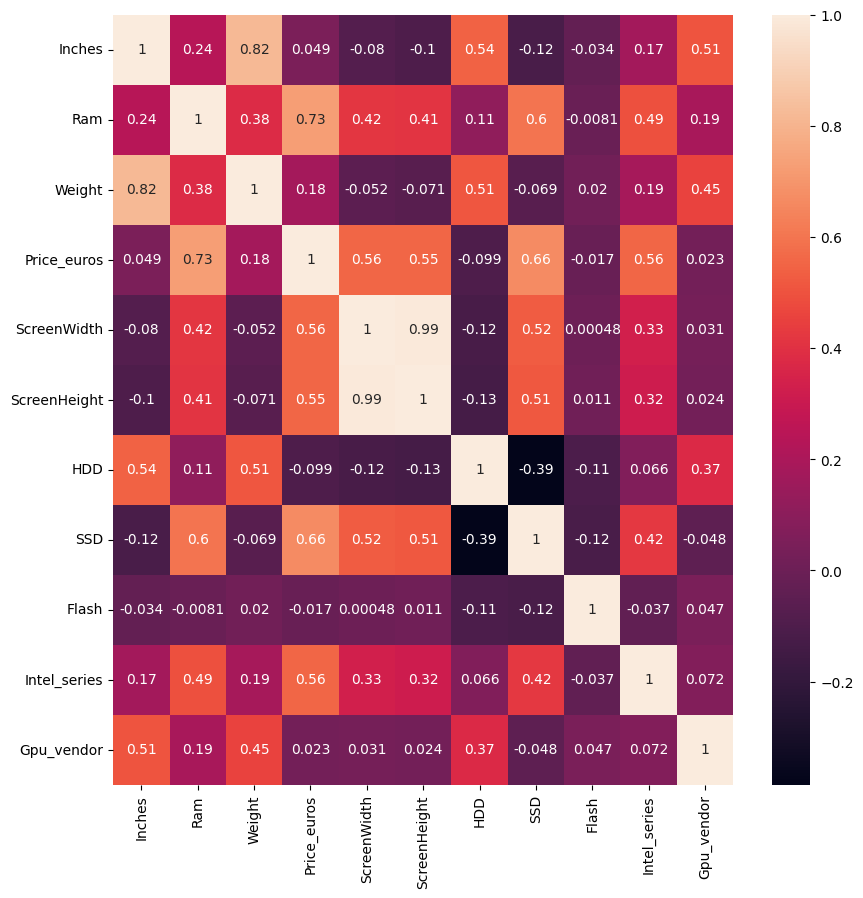

In [9]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True)
None

Из матрицы корреляции видно, что Flash имеет очень низкий коэффициент. Уберем этот признак.

In [10]:
data.drop(columns=["Flash"], inplace=True)

In [11]:
X = data.drop(columns=["Price_euros"])
y = data["Price_euros"]

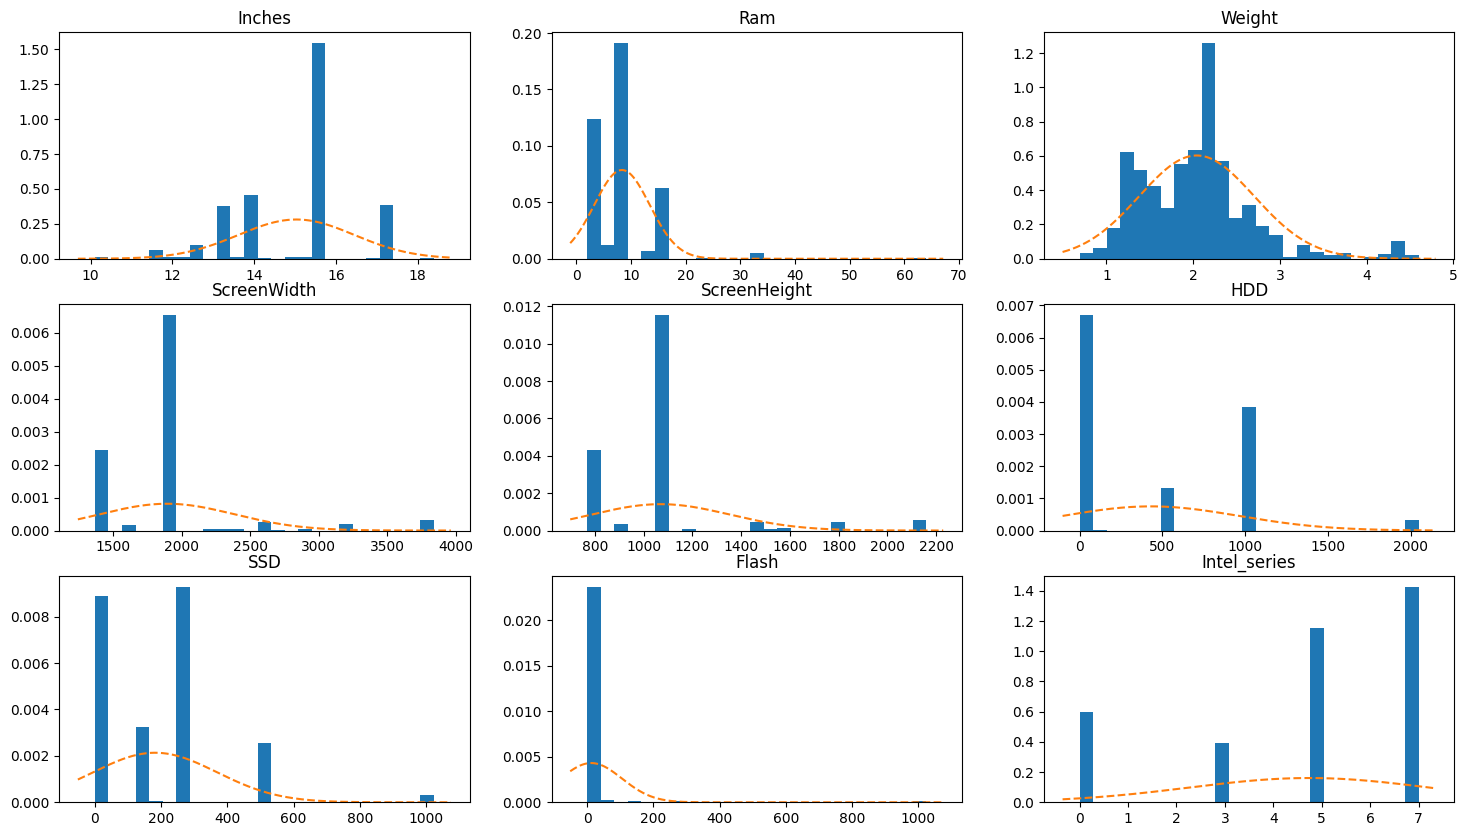

In [12]:
keys = X.columns

fig, axes = plt.subplots(3, 3)
fig.set_size_inches(6 * 3, 10)

for key, ax in zip(keys, [ax for ax in axes.flatten()]):
    ax.hist(X[key], density=True, bins=25)
    
    loc = X[key].mean()
    scale = X[key].std()
    
    x_left, x_right = ax.get_xlim()
    x_tmp = np.linspace(x_left, x_right, 10000)
    y_tmp = stats.norm.pdf(x_tmp, loc=loc, scale=scale)
    
    ax.plot(x_tmp, y_tmp, linestyle='dashed')
    ax.set_title(key)

## Нормировка данных и разбиение на train и test выборки

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

reg = LinearRegression()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=49)

In [14]:
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mean_squared_error(y_test, y_pred)

120035.30785625664

In [15]:
reg = reg.fit(X_scaled, y)

## Predict

In [16]:
df = pd.read_csv("Price_euros_test.csv")
X_test = df.fillna(method="bfill")

X_test = clean_data(X_test)
X_test.drop(columns=["Flash"], inplace=True)

X_test_scaled = scaler.fit_transform(X_test)

In [17]:
y_pred = reg.predict(X_test_scaled)

ans = pd.DataFrame({"Index": [i for i in range(len(y_pred))], "Price_euros": y_pred})
ans.to_csv("answer.csv", sep=",", index=False)
ans.describe()

,Index,Price_euros
count,195.000000,195.000000
mean,97.000000,1115.214612
std,56.435804,590.243495
min,0.000000,141.792584
25%,48.500000,691.842234
50%,97.000000,1118.348575
75%,145.500000,1303.339398
max,194.000000,3748.988589
